# Skincancer HAM-dataset med Pytorch

### Standardimporter

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import torch.optim as optim
from torch.optim import lr_scheduler
import os

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
%matplotlib inline

### Definiera de olika mängderna för träning, validering och test:

In [2]:
batchsz = 2**5

# Definiera vilken augmentation som ska göras:
train_data_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

val_test_data_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

basepath = "../../../ml/Datasets/skin-cancer-mnist-ham10000/images_per_label_splitted_sets/"

# Definiera de tre dataseten:
skincancer_train_dataset = datasets.ImageFolder(root = basepath + 'train/',
                                           transform = train_data_transform)

skincancer_valid_dataset = datasets.ImageFolder(root = basepath + 'val/',
                                           transform = val_test_data_transform)

skincancer_test_dataset = datasets.ImageFolder(root = basepath + 'test/',
                                              transform = val_test_data_transform)

# Skapa loaders för de tre dataseten:
train_loader = torch.utils.data.DataLoader(skincancer_train_dataset,
                                             batch_size = batchsz, shuffle = True,
                                             num_workers = 4)

valid_loader = torch.utils.data.DataLoader(skincancer_valid_dataset,
                                             batch_size = batchsz, shuffle = True,
                                             num_workers = 4)

test_loader = torch.utils.data.DataLoader(skincancer_test_dataset,
                                             batch_size = batchsz, shuffle = False,
                                             num_workers = 4)

### Create code for moving to GPU, if available

In [3]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [4]:
device = get_default_device()

In [5]:
print(device)

cuda


### De båda nedanstående blocken används för att enkelt flytta till GPU: 

In [6]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [7]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

### Flytta train_loader och test_loader till GPU:n

In [8]:
train_dl = DeviceDataLoader(train_loader, device)
valid_dl = DeviceDataLoader(valid_loader, device)
test_dl = DeviceDataLoader(test_loader, device)

In [9]:
train_dl.device

device(type='cuda')

In [10]:
valid_dl.device

device(type='cuda')

In [11]:
test_dl.device

device(type='cuda')

In [12]:
targets = train_loader.dataset.targets
print(len(targets))

7007


#### Hur blir tensor-storlekarna när de flödar genom ett eget CNN-nät?

In [13]:
# Hämta en batch med bilder:

for x, labels in train_loader:
    print("Ursprunglig storlek: ", x.shape)
    break

Ursprunglig storlek:  torch.Size([32, 3, 224, 224])


In [14]:
x = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 5, stride = 2)(x)
print("Efter Conv2d(1, 3, 5, 2): ", x.shape)

Efter Conv2d(1, 3, 5, 2):  torch.Size([32, 16, 110, 110])


In [15]:
x = nn.MaxPool2d(kernel_size = 2, stride = 2)(x)
print("Efter Pooling, kernel_size = 2, stride = 2 så blir storleken: ", x.shape)

Efter Pooling, kernel_size = 2, stride = 2 så blir storleken:  torch.Size([32, 16, 55, 55])


In [16]:
x = nn.Conv2d(in_channels = 16, out_channels = 64, kernel_size = 5, stride = 2)(x)
print(x.shape)

torch.Size([32, 64, 26, 26])


In [17]:
x = nn.MaxPool2d(kernel_size = 2, stride = 2)(x)
print("Efter Pooling, kernel_size = 2, stride = 2 så blir storleken: ", x.shape)

Efter Pooling, kernel_size = 2, stride = 2 så blir storleken:  torch.Size([32, 64, 13, 13])


In [18]:
x = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 2)(x)
print(x.shape)

torch.Size([32, 128, 6, 6])


In [19]:
x = nn.MaxPool2d(kernel_size = 2, stride = 2)(x)
print("Efter Pooling, kernel_size = 2, stride = 2 så blir storleken: ", x.shape)

Efter Pooling, kernel_size = 2, stride = 2 så blir storleken:  torch.Size([32, 128, 3, 3])


In [20]:
# Fånga automatiskt tensorn från CNN-delen som ska 
# formas om till en vektor:

x.view(-1, x.shape[1]*x.shape[2]*x.shape[3]).shape

torch.Size([32, 1152])

### Bygg ett eget CNN-nät:

In [21]:
num_classes = 7

In [22]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNetwork, self).__init__()
        self.image_layer1 = nn.Sequential(
            nn.Conv2d(3, 16, 4, 1, 0), # (in, out, kernelsz, stride, padding) 224 --> 221 px
            nn.MaxPool2d(2), # 221 --> 110 px
            nn.ReLU(),
        )
        
        self.image_layer2 = nn.Sequential(
            nn.Conv2d(16, 64, 6, 1, 0), # (in, out, kernelsz, stride) 110 --> 105 px
            nn.MaxPool2d(2), # 105 --> 52 px
            nn.ReLU(),
        )
        
        self.image_layer3 = nn.Sequential(
            nn.Conv2d(64, 128, 5, 2, 0), # (in, out, kernelsz, stride) 52 -->  24 px
            nn.MaxPool2d(2), # 24 --> 12 px
            nn.ReLU(),
        )
        
        self.image_layer4 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 0), # (in, out, kernelsz, stride) 12 -->  10 px
            nn.MaxPool2d(2), # 10 --> 5 px
            nn.ReLU(),
        )

 
        self.classifier = nn.Sequential(
            nn.Linear(5*5*256, 512),
            nn.Linear(512, 256),
            nn.Linear(256, 64),
            nn.Dropout(p = 0.3),
            nn.Linear(64, num_classes),
            )
        
    def forward(self, x):
        x = self.image_layer1(x)
        x = self.image_layer2(x)
        x = nn.Dropout(p = 0.3)(x)
        x = self.image_layer3(x)
        x = self.image_layer4(x)
        x = nn.Dropout(p = 0.3)(x)

        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        #return F.log_softmax(x, dim = 1)
        return x
        

In [23]:
torch.manual_seed(17)
model = ConvolutionalNetwork()

In [24]:
trainableparameters = []
for param in model.parameters():
    # trainableparameters = param.numel()
    trainableparameters.append(param.numel())

print("Antalet träningsbara parametrar är =", np.sum(trainableparameters), "st.")


Antalet träningsbara parametrar är = 3963351 st.


### Flytta modellen till GPU, om en sådan finns:

In [25]:
# Flytta modellen till GPU:

to_device(model, device)

ConvolutionalNetwork(
  (image_layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (image_layer2): Sequential(
    (0): Conv2d(16, 64, kernel_size=(6, 6), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (image_layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (image_layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=6400, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=64, b

In [26]:
# Verifiera att modellen är på rätt device:
# True => modellen finns på GPU.

next(model.parameters()).is_cuda

True

### Define loss function & optimizer

In [27]:
# Definiera loss-function och vilken optimerare som ska användas:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

### Trainingloop:

In [28]:
for idx_train, (inputs_train, labels_train) in enumerate(train_dl):
    break

In [29]:
# Följande återställer modellens vikter
# mellan körningar:

# usage: model.apply(weights_init)

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight.data)

In [31]:
epochs=10

In [32]:
model.apply(weights_init)

do_validation = 1

import time
start_training_time = time.time()

num_training_images = len(train_loader.dataset)
num_val_images = len(valid_loader.dataset)

accuracy_train = []
losses_train = []
accuracy_val = []
losses_val = []

for epoch in range(epochs):
    start_epoch_time = time.time()
    
    num_correct_per_epoch_train = 0
    tot_loss_per_epoch_train = 0.0
 
    for inputs_train, labels_train in train_dl:
        images_train = inputs_train.to(device)
        labels_train = labels_train.to(device)
        
        model.train()
        # Låt modellen göra förutsägelser:
        predictions_train = model.forward(images_train)
        
        # Beräkna statistik från träningen på träningsmängden:
        _, predicted_train = torch.max(predictions_train.data, 1)
        num_correct_per_batch_train = torch.sum(predicted_train.detach() == labels_train.detach())
        num_correct_per_epoch_train += num_correct_per_batch_train
        
        # Beräkna loss:
        loss_per_batch_train = criterion(predictions_train, labels_train)
        tot_loss_per_epoch_train += loss_per_batch_train.item() * batchsz
        
        # Nolla ackadumulerade gradienter, göra 
        # backprop. & uppdatera vår optimeringsfunktion:
        optimizer.zero_grad()
        loss_per_batch_train.backward()
        optimizer.step()
        
    # Validation
    if do_validation == True:
        start_eval_time = time.time()
        model.eval()
        
        num_correct_per_epoch_val = 0
        tot_loss_per_epoch_val = 0.0
        
        for inputs_val, labels_val in valid_dl:
            images_val = inputs_val.to(device)
            labels_val = labels_val.to(device)
        
            with torch.no_grad():
                            
                predictions_val = model.forward(images_val)
                _, predicted_val = torch.max(predictions_val, 1)
                # Behöver ej använda .detach med torch.no_grad()
                num_correct_per_batch_val = torch.sum(predicted_val == labels_val)
                #num_correct_per_batch_val = torch.sum(predicted_val.detach() == labels_val.detach())
                num_correct_per_epoch_val += num_correct_per_batch_val
                
                loss_per_batch_val = criterion(predictions_val, labels_val) 
                tot_loss_per_epoch_val += loss_per_batch_val.item() * batchsz
        
        end_eval_time = time.time()
    else:
        pass
    
    # Beräkna statistik från epoken:
    # Use torch.Tensor.item() to get a Python number 
    # from a tensor containing a single value:
    
    # acc, train:
    accuracy_per_epoch_train = num_correct_per_epoch_train.item() / num_training_images
    accuracy_train.append(accuracy_per_epoch_train)
        
    # loss, train:
    loss_per_epoch_train = tot_loss_per_epoch_train / num_training_images
    losses_train.append(loss_per_epoch_train)
    
    if do_validation == True:
        # acc, val:
        accuracy_per_epoch_val = num_correct_per_epoch_val.item() / num_val_images
        accuracy_val.append(accuracy_per_epoch_val)
        
        # loss, val:
        loss_per_epoch_val = tot_loss_per_epoch_val / num_val_images
        losses_val.append(loss_per_epoch_val)
    else:
        pass
    
    end_epoch_time = time.time()
    epoch_time = end_epoch_time - start_epoch_time
    
    # epoch startar på 0, därav "+1" nedan:
    if do_validation == True:
        print(f"Epok {epoch+1:03}, {epoch_time:4.1f} sek. --- train acc = {accuracy_per_epoch_train:4.3f} --- val acc = {accuracy_per_epoch_val:4.3f} --- train loss = {loss_per_epoch_train:4.5f} --- val loss = {loss_per_epoch_val:4.5f}")
    else:
        print(f"Epok {epoch+1:03}, {epoch_time:4.1f} sek. --- train acc = {accuracy_per_epoch_train:4.3f} --- train loss = {loss_per_epoch_train:4.5f}")
    
end_training_time = time.time()

delta = end_training_time - start_training_time

print(f'\nTraining took {delta/60:.2f} minutes.')    

Epok 001, 106.8 sek. --- train acc = 0.666 --- val acc = 0.671 --- train loss = 1.07096 --- val loss = 0.96233
Epok 002, 26.7 sek. --- train acc = 0.665 --- val acc = 0.673 --- train loss = 0.93513 --- val loss = 0.92877
Epok 003, 26.8 sek. --- train acc = 0.676 --- val acc = 0.690 --- train loss = 0.89734 --- val loss = 0.83439
Epok 004, 26.2 sek. --- train acc = 0.681 --- val acc = 0.682 --- train loss = 0.87261 --- val loss = 0.85115
Epok 005, 26.4 sek. --- train acc = 0.683 --- val acc = 0.700 --- train loss = 0.86750 --- val loss = 0.87748
Epok 006, 26.5 sek. --- train acc = 0.687 --- val acc = 0.701 --- train loss = 0.84916 --- val loss = 0.84262
Epok 007, 26.7 sek. --- train acc = 0.696 --- val acc = 0.702 --- train loss = 0.83432 --- val loss = 0.86355
Epok 008, 27.0 sek. --- train acc = 0.699 --- val acc = 0.707 --- train loss = 0.81217 --- val loss = 0.81531
Epok 009, 26.4 sek. --- train acc = 0.702 --- val acc = 0.710 --- train loss = 0.80906 --- val loss = 0.83048
Epok 010,

### Plotta accuracy och loss:

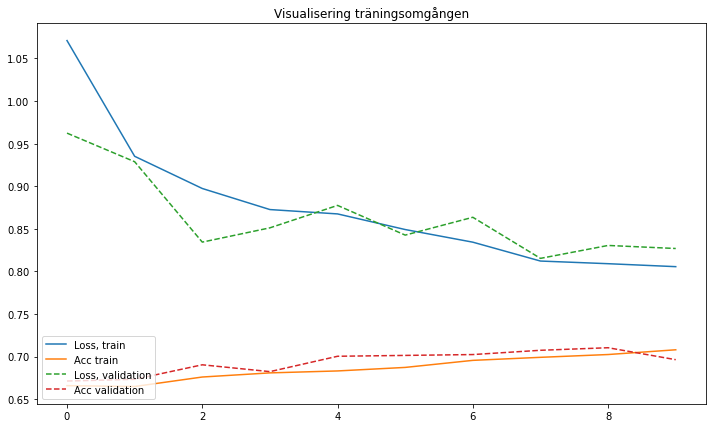

In [33]:
if do_validation == False:

    plt.figure(figsize = (12, 7))
    plt.title("Visualisering träningsomgången")
    plt.plot(losses_train, label = "Loss")
    plt.plot(accuracy_train, label = "Andel korrekta")
    plt.legend()
    plt.show()
else:
    plt.figure(figsize = (12, 7))
    plt.title("Visualisering träningsomgången")
    plt.plot(losses_train, label = "Loss, train")
    plt.plot(accuracy_train, label = "Acc train")
    plt.plot(losses_val, label = "Loss, validation", linestyle='dashed')
    plt.plot(accuracy_val, label = "Acc validation", linestyle='dashed')
    plt.legend(loc = 'lower left')
    plt.show()

### Utvärdera

In [34]:
def evaluate_model(num_eval_images, data_generator, model):

    model.eval()

    start_eval_test_time = time.time()
    
    global labels_val_true_np, predicted_val_np
    
    labels_ground_truth = []
    predicted_classes_val = []
    
    with torch.no_grad():
        correct_val = 0
        # Antal iterationer = num_images / batchsz = x st.
        for inputs, labels in data_generator:
            images = inputs.to(device)
            
            labels = labels.to(device)
            
            # Spara för mer utvärdering utanför denna funktion:
            labels_ground_truth.append(labels.cpu().numpy())
        
            # Låt modellen göra förutsägelser:
            predictions_val = model.forward(images)
            _, predicted_val = torch.max(input = predictions_val, dim = 1)
            predicted_classes_val.append(predicted_val.cpu().numpy())
            
            correct_val += (predicted_val == labels).sum()

        # Platta till listorna...
        labels_ground_truth = [item for sublist in labels_ground_truth for item in sublist]
        predicted_classes_val = [item for sublist in predicted_classes_val for item in sublist]
        
        #flat_list = []
        #for sublist in predicted_classes_val:
        #    for item in sublist:
        #        flat_list.append(item)
        
        labels_val_true_np = np.array(labels_ground_truth)
        predicted_val_np = np.array(predicted_classes_val)        
        
        end_eval_test_time = time.time()
        eval_test_time = end_eval_test_time - start_eval_test_time

    print(f'Test accuracy: {correct_val.item()}/{num_eval_images} = {100*correct_val.item()/(num_eval_images):5.2f} %')
    print(f"\nEvaluation took {eval_test_time:.2f} seconds.")

In [35]:
evaluate_model(len(valid_loader.dataset), valid_dl, model)

Test accuracy: 709/998 = 71.04 %

Evaluation took 3.47 seconds.


In [36]:
cm_pytorch = confusion_matrix(labels_val_true_np, predicted_val_np)

In [37]:
print(cm_pytorch)

[[  0   4   6   0   0  22   0]
 [  0   8   2   0   1  39   1]
 [  0   0  23   0   8  78   0]
 [  0   0   0   0   1   9   1]
 [  0   0  10   0  12  87   2]
 [  0   0   4   0   6 660   0]
 [  0   1   0   0   1   6   6]]


In [38]:
print(classification_report(labels_val_true_np, predicted_val_np))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.62      0.16      0.25        51
           2       0.51      0.21      0.30       109
           3       0.00      0.00      0.00        11
           4       0.41      0.11      0.17       111
           5       0.73      0.99      0.84       670
           6       0.60      0.43      0.50        14

    accuracy                           0.71       998
   macro avg       0.41      0.27      0.29       998
weighted avg       0.63      0.71      0.64       998



/home/johan/anaconda3/envs/pytorch_general/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
